In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

import matplotlib  
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
## Neural network tools
def get_batches(arrays, batch_size=None, randomise=False, include_remainder=True):
    length = len(arrays[0])
    idx = np.arange(length)

    if randomise:
        np.random.shuffle(idx)

    n_full_batches = length // batch_size
    is_remainder = (length % batch_size > 0)

    if is_remainder and include_remainder:
        n_batches = n_full_batches + 1
    else:
        n_batches = n_full_batches

    for i_batch in range(n_batches):
        if i_batch < n_full_batches:
            batch_idx = idx[i_batch*batch_size:(i_batch+1)*batch_size]
        else:
            batch_idx = idx[i_batch*batch_size:]

        arrays_batch = [torch.Tensor(array[batch_idx]) for array in arrays]
        yield arrays_batch

def get_total_loss(model, loss, X, y, mean_over_batch=False):
    eval_batch_size = min(1024*2**8,len(X))
    losses = [] # contain loss from every batch

    with torch.no_grad():
        for X_tensor, y_tensor in get_batches([X, y], eval_batch_size):
            output = model(X_tensor)
            losses.append(loss(output, y_tensor).item()*len(output))

        if mean_over_batch:
            mean_loss = sum(losses) / len(losses)
        else:
            mean_loss = sum(losses) / len(X)

    return mean_loss

def get_network_output(df, features, model):
    with torch.no_grad():
        X = df[features].to_numpy() #Now check what corrections are for test_df

        eval_batch_size = min(1024*2**8,len(df))
        outputs = []

        for X_tensor, in get_batches([X], eval_batch_size):
              outputs.append(model(X_tensor).numpy())

        output = np.concatenate(outputs)

    return output

In [3]:
# Two datasets: 1D
lambda_a, lambda_b = 3.5, 3.0

f_a = torch.distributions.exponential.Exponential(rate=lambda_a)
f_b = torch.distributions.exponential.Exponential(rate=lambda_b)

In [4]:
# Simulate events and store in dataframe
def generate_simulation(f, N, type='a'):
    events = f.sample((N,1))
    df = pd.DataFrame(events, columns=['x'])
    if type == 'a':
        df['is_a'] = 1
        df['is_b'] = 0
    else:
        df['is_a'] = 0
        df['is_b'] = 1
    return df

In [5]:
N = 100000
df_a = generate_simulation(f_a, N, type='a')
df_b = generate_simulation(f_b, N, type='b')

# Add Z-score adjusted variable
m = np.concatenate([df_a['x'],df_b['x']]).mean()
s = np.concatenate([df_a['x'],df_b['x']]).std()
df_a['xT'] = (df_a['x']-m)/s
df_b['xT'] = (df_b['x']-m)/s

Text(0, 0.5, 'Entries')

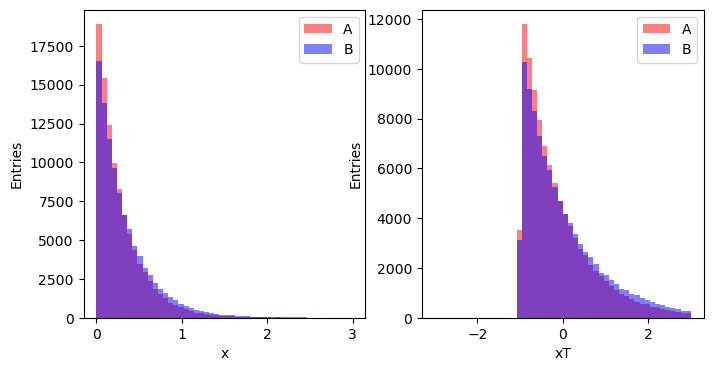

In [6]:
nbins = 50
xrange = (0,3)

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].hist(df_a['x'], bins=nbins, range=xrange, label='A', color='red', alpha=0.5)
axs[0].hist(df_b['x'], bins=nbins, range=xrange, label='B', color='blue', alpha=0.5)
axs[0].legend(loc='best')
axs[0].set_xlabel("x")
axs[0].set_ylabel("Entries")

axs[1].hist(df_a['xT'], bins=nbins, range=(-3,3), label='A', color='red', alpha=0.5)
axs[1].hist(df_b['xT'], bins=nbins, range=(-3,3), label='B', color='blue', alpha=0.5)
axs[1].legend(loc='best')
axs[1].set_xlabel("xT")
axs[1].set_ylabel("Entries")

In [7]:
# Train neural network to classify between S and B
train_hp = {
    "lr":0.0001,
    "batch_size":1000,
    "N_epochs":100,
    "seed":0
}

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(train_hp['seed'])

In [8]:
class Net(nn.Module):
    def __init__(self, n_features=3, nodes=[100,100], output_nodes=1):
        super(Net, self).__init__()
        # Build network
        n_nodes = [n_features] + nodes + [output_nodes]
        self.layers = nn.ModuleList()
        for i in range(len(n_nodes)-1):
            self.layers.append(nn.Linear(n_nodes[i], n_nodes[i+1]))
            #self.layers.append(nn.ReLU())
            self.layers.append(nn.Tanh())

    def forward(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        # Apply softmax
        return torch.sigmoid(out)

In [9]:
# Function to train network with cross entropy loss
def train_network_cross_entropy(model, train_df, test_df, features=['xT'], train_hp={}):
    optimiser = torch.optim.Adam(model.parameters(), lr=train_hp["lr"])

    X_train = train_df[features].to_numpy()
    X_test = test_df[features].to_numpy()
    y_train = train_df[["is_a"]].to_numpy()
    y_test = test_df[["is_a"]].to_numpy()

    ce_loss = nn.BCELoss()
    train_loss, test_loss = [], []

    print(">> Training...")
    with tqdm(range(train_hp["N_epochs"])) as t:
        for i_epoch in t:
            model.train()

            # "get_batches": function defined in statml_tools.py to separate the training data into batches
            batch_gen = get_batches([X_train, y_train], batch_size=train_hp['batch_size'],
                                    randomise=True, include_remainder=False
                                   )
            
            for X_tensor, y_tensor in batch_gen:
                optimiser.zero_grad()
                output = model(X_tensor)
                loss = ce_loss(output, y_tensor)
                loss.backward()
                optimiser.step()

            model.eval()
            # "get_total_loss": function defined in statml_tools.py to evaluate the network in batches (useful for large datasets)
            train_loss.append(get_total_loss(model, ce_loss, X_train, y_train))
            test_loss.append(get_total_loss(model, ce_loss, X_test, y_test))
            t.set_postfix(train_loss=train_loss[-1], test_loss=test_loss[-1])

    print(">> Training finished")
    model.eval()

    return model, train_loss, test_loss

In [10]:
# Do test-train split for simulated data
A_train, A_test = train_test_split(df_a, test_size=0.5, random_state=train_hp['seed'])
B_train, B_test = train_test_split(df_b, test_size=0.5, random_state=train_hp['seed'])
train_df = pd.concat([A_train, B_train]).sample(frac=1)
test_df = pd.concat([A_test, B_test]).sample(frac=1)

In [11]:
# Initialise network
model_bce = Net(n_features=1, nodes=[10,10], output_nodes=1)

In [12]:
# Train network
model_bce, train_loss_bce, test_loss_bce = train_network_cross_entropy(model_bce, train_df, test_df, train_hp=train_hp)

>> Training...


100%|██████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.22it/s, test_loss=0.691, train_loss=0.69]

>> Training finished


Text(0, 0.5, 'BCE loss')

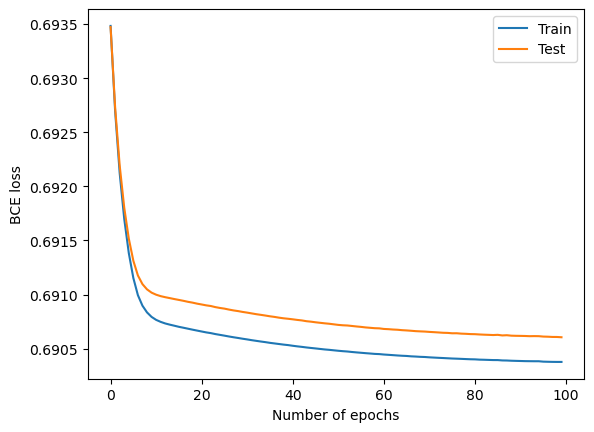

In [13]:
# Plot loss function curves
fig, ax = plt.subplots()
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), train_loss_bce, label="Train")
ax.plot(np.linspace(0,train_hp["N_epochs"]-1,train_hp["N_epochs"]), test_loss_bce, label="Test")
ax.legend(loc='best')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("BCE loss")

In [14]:
# Add BCE network output to dataframes 
df_a['nn_bce'] = model_bce(torch.tensor(df_a[['xT']].to_numpy())).detach()
df_b['nn_bce'] = model_bce(torch.tensor(df_b[['xT']].to_numpy())).detach()

Text(0, 0.5, 'w')

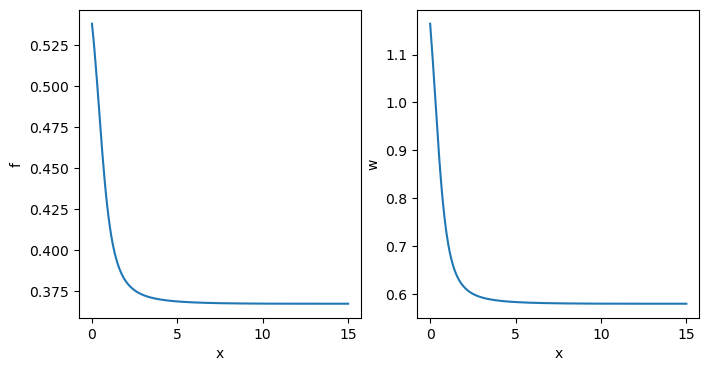

In [26]:
x_arr = np.linspace(0,15,200, dtype='float32')
xT_arr = (x_arr-m)/s
f = model_bce(torch.tensor(pd.DataFrame(xT_arr).to_numpy())).detach()
w = f/(1-f)

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot(x_arr, f)
axs[0].set_xlabel("x")
axs[0].set_ylabel("f")

axs[1].plot(x_arr, w)
axs[1].set_xlabel("x")
axs[1].set_ylabel("w")

In [16]:
df_b['rwgt'] = df_b['nn_bce']/(1-df_b['nn_bce'])

Text(0, 0.5, 'Entries')

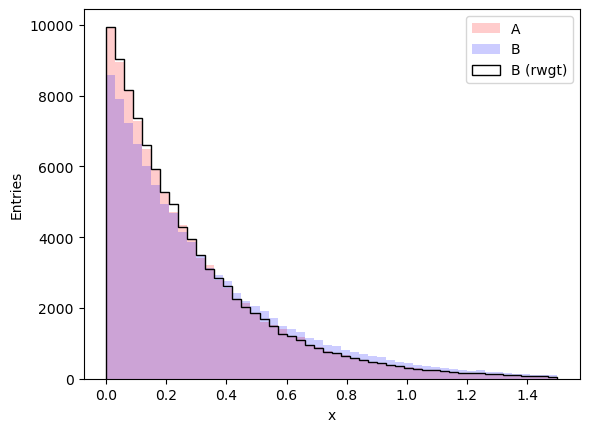

In [17]:
nbins = 50
xrange = (0,1.5)

fig, ax = plt.subplots()
ax.hist(df_a['x'], bins=nbins, range=xrange, label='A', color='red', alpha=0.2)
ax.hist(df_b['x'], bins=nbins, range=xrange, label='B', color='blue', alpha=0.2)
ax.hist(df_b['x'], bins=nbins, range=xrange, label='B (rwgt)', color='black', histtype='step', weights=df_b['rwgt'])
ax.legend(loc='best')
ax.set_xlabel("x")
ax.set_ylabel("Entries")
#ax.set_yscale("log")

In [18]:
# Total sum of weights
A = len(df_a)
B = len(df_b)
B_rwgt = df_b['rwgt'].sum()
print(f"Norm: A = {A}, B = {B}, B(rwgt) = {B_rwgt}")

Norm: A = 100000, B = 100000, B(rwgt) = 100465.34375


Text(0, 0.5, 'Entries')

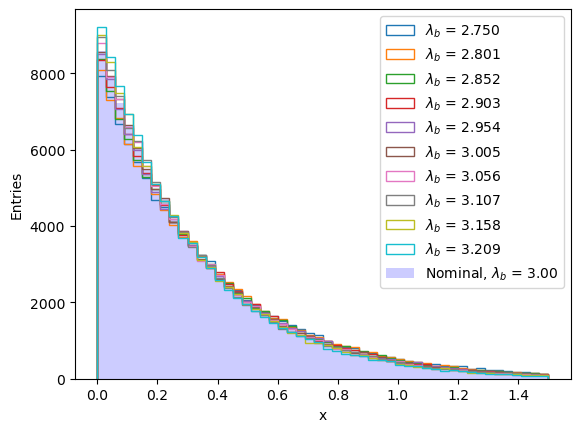

In [19]:
# Generate new background with slightly changed distribution
lambda_bprime = np.linspace(2.75,3.25,50)
N = 100000
Bprime_rwgt = []

fig, ax = plt.subplots()

for i, lb in enumerate(lambda_bprime):

    f_bprime = torch.distributions.exponential.Exponential(rate=lb)
    df_bprime = generate_simulation(f_bprime, N, type='b')
    if i % 5 == 0:
        ax.hist(df_bprime['x'], bins=nbins, range=xrange, label=f"$\lambda_b$ = {lb:.3f}", histtype='step')

    df_bprime['xT'] = (df_bprime['x']-m)/s
    df_bprime['nn_bce'] = model_bce(torch.tensor(df_bprime[['xT']].to_numpy())).detach()
    df_bprime['rwgt'] = df_bprime['nn_bce']/(1-df_bprime['nn_bce'])
    Bprime_rwgt.append(df_bprime['rwgt'].sum())

ax.hist(df_b['x'], bins=nbins, range=xrange, label=f"Nominal, $\lambda_b$ = {lambda_b:.2f}", color='blue', alpha=0.2)
ax.legend(loc='best')
ax.set_xlabel("x")
ax.set_ylabel("Entries")

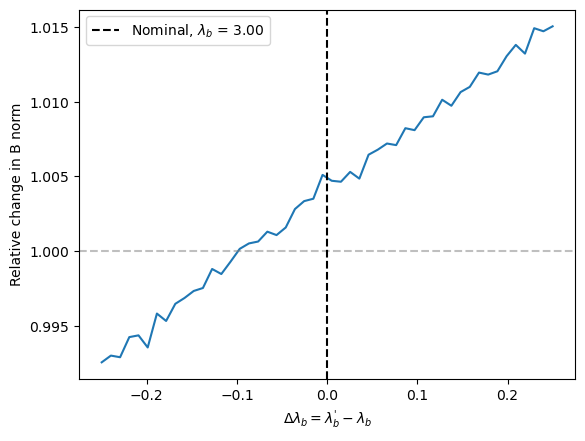

In [20]:
# Plot normalisation as a function of delta_lambda
delta_lambda = lambda_bprime - lambda_b
fig, ax = plt.subplots()
ax.plot(delta_lambda, np.array(Bprime_rwgt)/B)
ax.set_xlabel("$\Delta\lambda_b = \lambda^'_b - \lambda_b$")
ax.set_ylabel("Relative change in B norm")
ax.axhline(1, color='grey', ls='--', alpha=0.5)
ax.axvline(lambda_b-lambda_b, color='black', ls='--', label=f"Nominal, $\lambda_b$ = {lambda_b:.2f}")
ax.legend(loc='best')

In [21]:
# Add normalisation factor from nominal dataset
norm_factor = (B/B_rwgt)
df_b['rwgt_normed'] = df_b['rwgt']*norm_factor

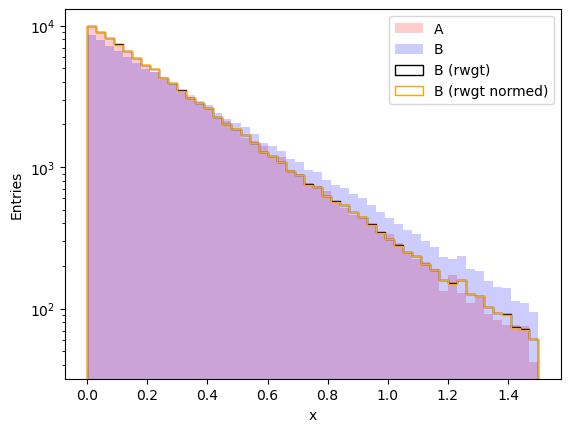

In [22]:
nbins = 50
xrange = (0,1.5)

fig, ax = plt.subplots()
ax.hist(df_a['x'], bins=nbins, range=xrange, label='A', color='red', alpha=0.2)
ax.hist(df_b['x'], bins=nbins, range=xrange, label='B', color='blue', alpha=0.2)
ax.hist(df_b['x'], bins=nbins, range=xrange, label='B (rwgt)', color='black', histtype='step', weights=df_b['rwgt'])
ax.hist(df_b['x'], bins=nbins, range=xrange, label='B (rwgt normed)', color='orange', histtype='step', weights=df_b['rwgt_normed'])
ax.legend(loc='best')
ax.set_xlabel("x")
ax.set_ylabel("Entries")
ax.set_yscale("log")

In [23]:
# Generate new background with slightly changed distribution, using norm factor derived
lambda_bprime = np.linspace(2.75,3.25,50)
N = 100000
Bprime_rwgt = []

for i, lb in enumerate(lambda_bprime):

    f_bprime = torch.distributions.exponential.Exponential(rate=lb)
    df_bprime = generate_simulation(f_bprime, N, type='b')

    df_bprime['xT'] = (df_bprime['x']-m)/s
    df_bprime['nn_bce'] = model_bce(torch.tensor(df_bprime[['xT']].to_numpy())).detach()
    df_bprime['rwgt'] = df_bprime['nn_bce']/(1-df_bprime['nn_bce'])
    Bprime_rwgt.append(norm_factor*df_bprime['rwgt'].sum())

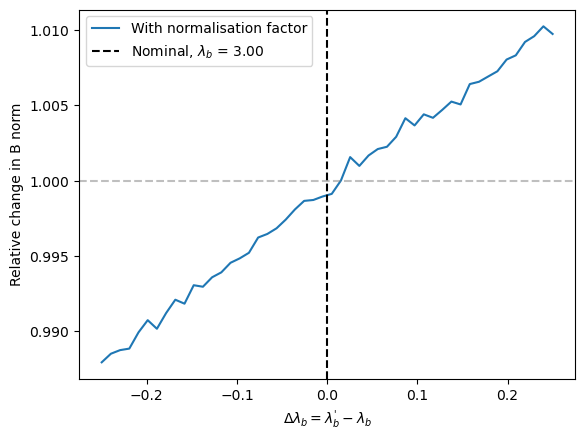

In [24]:
# Plot normalisation as a function of delta_lambda
delta_lambda = lambda_bprime - lambda_b
fig, ax = plt.subplots()
ax.plot(delta_lambda, np.array(Bprime_rwgt)/B, label="With normalisation factor")
ax.set_xlabel("$\Delta\lambda_b = \lambda^'_b - \lambda_b$")
ax.set_ylabel("Relative change in B norm")
ax.axhline(1, color='grey', ls='--', alpha=0.5)
ax.axvline(lambda_b-lambda_b, color='black', ls='--', label=f"Nominal, $\lambda_b$ = {lambda_b:.2f}")
ax.legend(loc='best')